# Decision Tree & Random Forest for WU Data

## Import Packages

In [51]:
import numpy as np
import pandas as pd
import random
import datetime
import sklearn
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


In [52]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Group/Energy-Usage-Prediction-Project/Zheyu/Used Data'

## Read Data

In [53]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Group/Energy-Usage-Prediction-Project/Zheyu/Used Data')

In [54]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

timestamp  Temperature  Dew Point  Humidity  Wind Speed  \
0  2006-09-20 00:00:00        13.89      12.22      88.0         5.0   
1  2006-09-20 00:30:00        13.89      12.22      88.0        13.0   
2  2006-09-20 01:00:00        13.89      10.00      77.0         8.0   
3  2006-09-20 01:30:00        13.89      11.11      82.0         8.0   
4  2006-09-20 02:00:00        15.00      12.22      82.0        10.0   

   Wind Gust  Pressure  Precip.  Operational Demand (MW)  
0        0.0      30.0      0.0                 1347.418  
1        0.0      30.0      0.0                 1312.708  
2        0.0      30.0      0.0                 1298.644  
3        0.0      30.0      0.0                 1288.972  
4        0.0      30.0      0.0                 1282.006

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270281 entries, 0 to 270280
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   timestamp                270281 non-null  object 
 1   Temperature              270281 non-null  float64
 2   Dew Point                270281 non-null  float64
 3   Humidity                 270281 non-null  float64
 4   Wind Speed               270281 non-null  float64
 5   Wind Gust                270281 non-null  float64
 6   Pressure                 270281 non-null  float64
 7   Precip.                  270281 non-null  float64
 8   Operational Demand (MW)  270281 non-null  float64
dtypes: float64(8), object(1)
memory usage: 20.6+ MB


In [56]:
df = df.rename(columns={'Temperature':'temperature(celcius)', 'Dew Point':'dew_point(celcius)', 'Humidity':'humidity(%)', 'Wind Speed':'wind_speed(mph)',
       'Wind Gust':'wind_gush(mph)', 'Pressure':'pressure(in)', 'Precip.':'precip.(in)'})

In [57]:
df.columns

Index(['timestamp', 'temperature(celcius)', 'dew_point(celcius)',
       'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
       'precip.(in)', 'Operational Demand (MW)'],
      dtype='object')

## Data Preparation

In [58]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
# split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
def create_time_features(df_in):
    df_in[['Date','Trading Interval Time']] = df_in['timestamp'].str.split(" ",expand=True)
    df_in['Date'] = pd.to_datetime(df_in['Date'])
    df_in['new_timestamp'] = pd.to_datetime(df_in['timestamp'], errors='coerce')
    df_in['year'] = df_in['new_timestamp'].dt.year
    df_in['month'] = df_in['new_timestamp'].dt.month
    df_in['day'] = df_in['new_timestamp'].dt.day
    df_in['hour'] = df_in['new_timestamp'].dt.hour
    df_in['minute'] = df_in['new_timestamp'].dt.minute
    df_in['Day_of_week'] = df_in['new_timestamp'].dt.dayofweek
    df_in['Day_of_month'] = df_in['new_timestamp'].dt.day
    df_in['Day_of_year'] = df_in['new_timestamp'].dt.dayofyear
    df_in['has_Wind'] = df_in['wind_speed(mph)'].apply(wind_ans) 
    df_in.set_index('timestamp', inplace=True, drop=True)
    df_in.reset_index(inplace=True)
    df_in.index = df_in['timestamp']
    df_out = df_in
    return df_out
df = create_time_features(df)
df.head()

timestamp  temperature(celcius)  \
timestamp                                                        
2006-09-20 00:00:00  2006-09-20 00:00:00                 13.89   
2006-09-20 00:30:00  2006-09-20 00:30:00                 13.89   
2006-09-20 01:00:00  2006-09-20 01:00:00                 13.89   
2006-09-20 01:30:00  2006-09-20 01:30:00                 13.89   
2006-09-20 02:00:00  2006-09-20 02:00:00                 15.00   

                     dew_point(celcius)  humidity(%)  wind_speed(mph)  \
timestamp                                                               
2006-09-20 00:00:00               12.22         88.0              5.0   
2006-09-20 00:30:00               12.22         88.0             13.0   
2006-09-20 01:00:00               10.00         77.0              8.0   
2006-09-20 01:30:00               11.11         82.0              8.0   
2006-09-20 02:00:00               12.22         82.0             10.0   

                     wind_gush(mph)  pressure(in)  precip.(in)  \
timestamp                                                        
2006-09-20 00:00:00             0.0          30.0          0.0   
2006-09-20 00:30:00             0.0          30.0          0.0   
2006-09-20 01:00:00             0.0          30.0          0.0   
2006-09-20 01:30:00             0.0          30.0          0.0   
2006-09-20 02:00:00             0.0          30.0          0.0   

                     Operational Demand (MW)       Date  ...  \
timestamp                                                ...   
2006-09-20 00:00:00                 1347.418 2006-09-20  ...   
2006-09-20 00:30:00                 1312.708 2006-09-20  ...   
2006-09-20 01:00:00                 1298.644 2006-09-20  ...   
2006-09-20 01:30:00                 1288.972 2006-09-20  ...   
2006-09-20 02:00:00                 1282.006 2006-09-20  ...   

                          new_timestamp  year  month  day  hour  minute  \
timestamp                                                                 
2006-09-20 00:00:00 2006-09-20 00:00:00  2006      9   20     0       0   
2006-09-20 00:30:00 2006-09-20 00:30:00  2006      9   20     0      30   
2006-09-20 01:00:00 2006-09-20 01:00:00  2006      9   20     1       0   
2006-09-20 01:30:00 2006-09-20 01:30:00  2006      9   20     1      30   
2006-09-20 02:00:00 2006-09-20 02:00:00  2006      9   20     2       0   

                     Day_of_week  Day_of_month  Day_of_year  has_Wind  
timestamp                                                              
2006-09-20 00:00:00            2            20          263         1  
2006-09-20 00:30:00            2            20          263         1  
2006-09-20 01:00:00            2            20          263         1  
2006-09-20 01:30:00            2            20          263         1  
2006-09-20 02:00:00            2            20          263         1  

[5 rows x 21 columns]

In [59]:
# def create_time_features(df_in):
#     df = df_in
#     df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#     df['Year'] = df['timestamp'].dt.year
#     df['Month'] = df['timestamp'].dt.month
#     df['Hour'] = df['timestamp'].dt.hour
#     df['Day_of_week'] = df['timestamp'].dt.dayofweek
#     df['Day_of_month'] = df['timestamp'].dt.day
#     df['Day_of_year'] = df['timestamp'].dt.dayofyear
#     df.set_index('timestamp', inplace=True, drop=True)
#     # df = df.astype('int')
#     df.reset_index(inplace=True)
#     time_features_df = df
#     return time_features_df
# df_a = create_time_features(df)
# df_a.columns.tolist()
# df_a.head()

In [60]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year','year','hour','minute']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df[select_col]
# training_dat = model_df[(model_df.index < '2020-12-01') | ('2021-04-01' <= model_df.index)]
training_dat = model_df[model_df.index < '2021-12-01']
testing_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


## Function Preparation

In [61]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [62]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Threshold Determine

125225.874

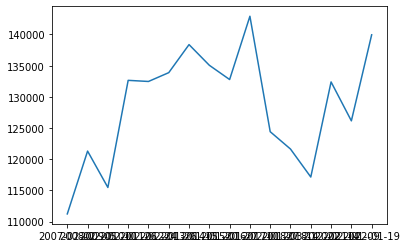

In [63]:
agg_all = model_df.copy()
agg_all['Date','time'] = agg_all.index.str.split(" ",expand=True)
agg_all[['Date', 'time']] = agg_all[('Date', 'time')].apply(pd.Series)

agg_all = agg_all.drop(labels=['time',('Date','time')], axis=1)
agg_all = pd.DataFrame(agg_all.groupby(['Date'])['Operational Demand (MW)'].sum())
new_df_summer = pd.DataFrame()
for i in range(2005,2022):
    s0 = str(i) + '-12-01'
    s1 = str(i+1) + '-04-01'
    df_summer = agg_all[(agg_all.index >= s0) & (s1 > agg_all.index)]
    order_table = df_summer.sort_values('Operational Demand (MW)',ascending=False)
    nr = order_table[3:4]
    new_df_summer = pd.concat((new_df_summer,nr))
od = new_df_summer['Operational Demand (MW)']
plt.plot(od.index,od)
year_choose = 3 # number of year we choose to get the average threshold
ave_threshold = sum(od[-4:-1])/year_choose
# ave_threshold= sum(od[:-1])/len(od[:-1])   
ave_threshold # same result for both threshold

In [64]:
od[:-1]

Date
2007-02-02    111219.334
2008-02-05    121297.178
2009-02-10    115460.272
2010-02-26    132645.194
2011-02-24    132465.406
2012-01-26    133880.634
2013-01-15    138378.508
2014-01-20    135063.762
2015-01-27    132775.894
2016-02-10    142928.122
2017-01-27    124407.598
2018-03-14    121625.992
2018-12-22    117137.326
2020-02-14    132391.970
2021-01-09    126148.326
Name: Operational Demand (MW), dtype: float64

## Decision Tree

In [65]:
tree_reg = DecisionTreeRegressor(random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree_test = grid_dtree.predict(X_test)
print(grid_dtree.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.8s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.8s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.8s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.6s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.6s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.6s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.6s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.6s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.6s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.7s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.7s
[CV] END ...................max_depth=15, min_sa

In [66]:
tree_model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=50, random_state=42)
tree_model.fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

In [67]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('tree_model')

Mean absolute error =  188.6891
Mean squared error =  64929.2385
Median absolute error =  133.9563
explained variance error =  0.814
R2 error =  0.7937
Mape 8.552636878032244
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     pressure(in)     | 0.2181 |
|     Day_of_week      | 0.0187 |
| temperature(celcius) | 0.019  |
|     humidity(%)      | 0.0014 |
|         year         |  0.0   |
|   wind_speed(mph)    | 0.001  |
|     Day_of_month     | 0.0711 |
|         hour         | 0.0026 |
|        minute        | 0.0554 |
|    wind_gush(mph)    | 0.1253 |
|  dew_point(celcius)  | 0.4846 |
|     Day_of_year      | 0.003  |
+----------------------+--------+


In [68]:
# fig = plt.figure(figsize=(16,12))
# a_rf_smote = plot_tree(tree_model, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [69]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

Operational Demand (MW)      predict
timestamp                                                
2021-12-01 00:00:00                 1788.716  1742.371213
2021-12-01 00:30:00                 1768.478  1742.371213
2021-12-01 01:00:00                 1756.662  1793.243867
2021-12-01 01:30:00                 1735.248  1793.243867
2021-12-01 02:00:00                 1724.418  1793.243867
...                                      ...          ...
2022-03-31 21:30:00                 2496.326  2447.144925
2022-03-31 22:00:00                 2418.866  2247.078337
2022-03-31 22:30:00                 2323.210  2247.078337
2022-03-31 23:00:00                 2245.612  2076.195871
2022-03-31 23:30:00                 2178.444  2247.078337

[5779 rows x 2 columns]

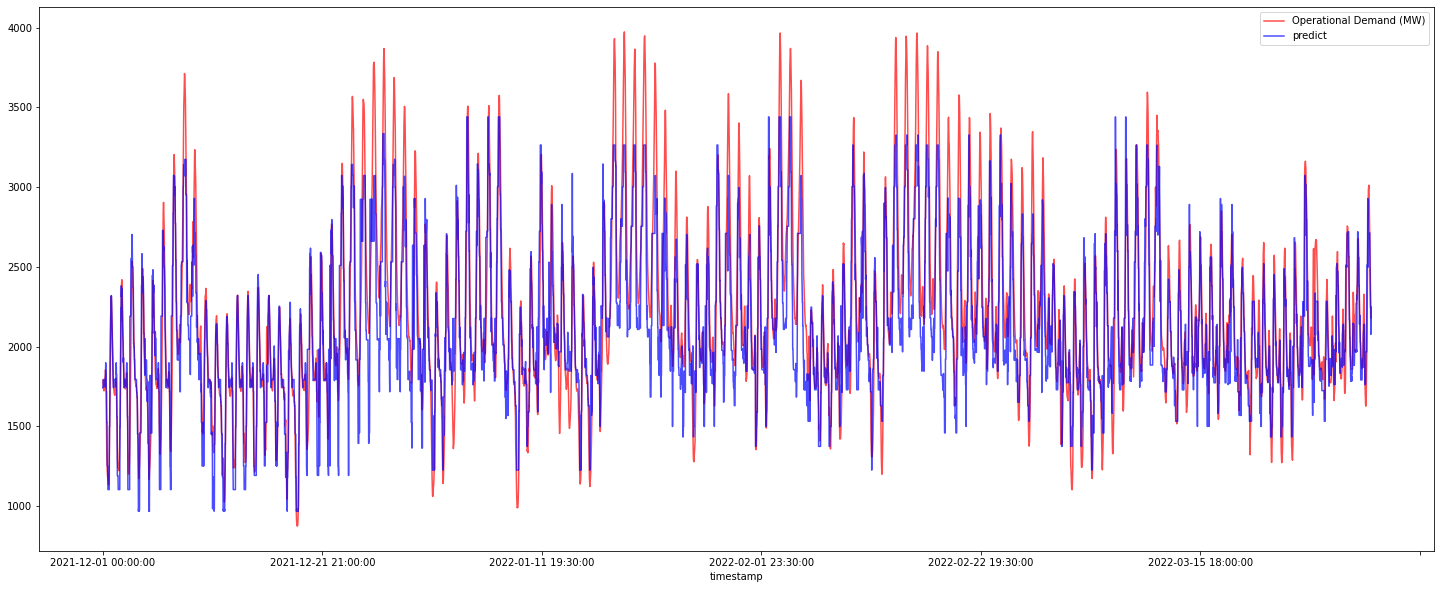

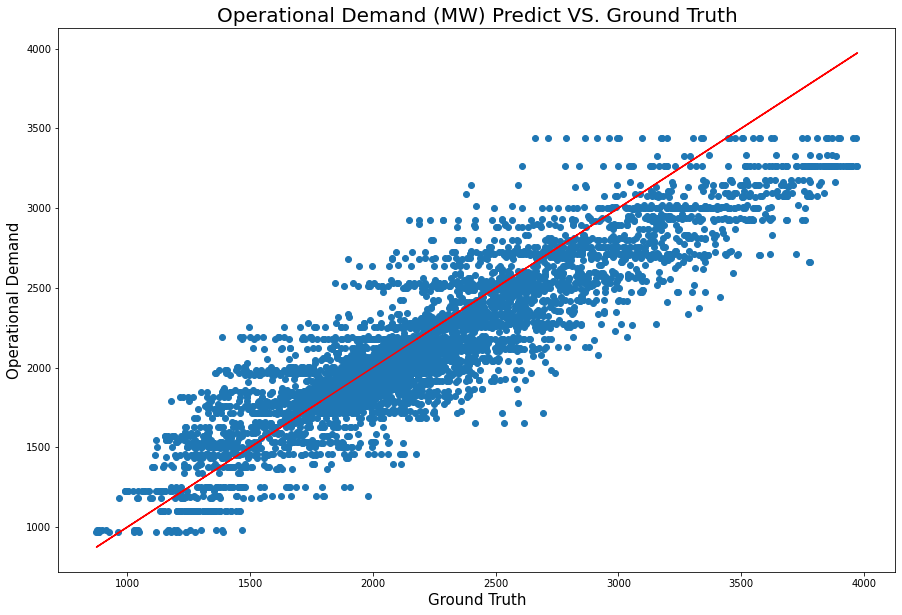

In [70]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [71]:
predict_table_tree['Date','time'] = predict_table_tree.index.str.split(" ",expand=True)
predict_table_tree[['Date', 'time']] = predict_table_tree[('Date', 'time')].apply(pd.Series)

predict_table_tree = predict_table_tree.drop(labels=['time',('Date','time')], axis=1)
agg_tree = pd.DataFrame(predict_table_tree.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())


In [72]:
tree_plot = agg_tree.copy()
tree_plot.index = tree_plot['Date']
tree_plot.drop('Date',axis=1)

Operational Demand (MW)        predict
Date                                              
2021-12-01                81389.002   82827.468064
2021-12-02                83692.208   82214.838144
2021-12-03                87674.768   91165.962259
2021-12-04                86230.014   84826.795332
2021-12-05                83724.146   87095.714174
...                             ...            ...
2022-03-27                94461.504   89254.908205
2022-03-28                96458.404   99039.506348
2022-03-29               100749.966  103491.947260
2022-03-30               105020.328  100394.327847
2022-03-31               105647.568  104571.796046

[121 rows x 2 columns]

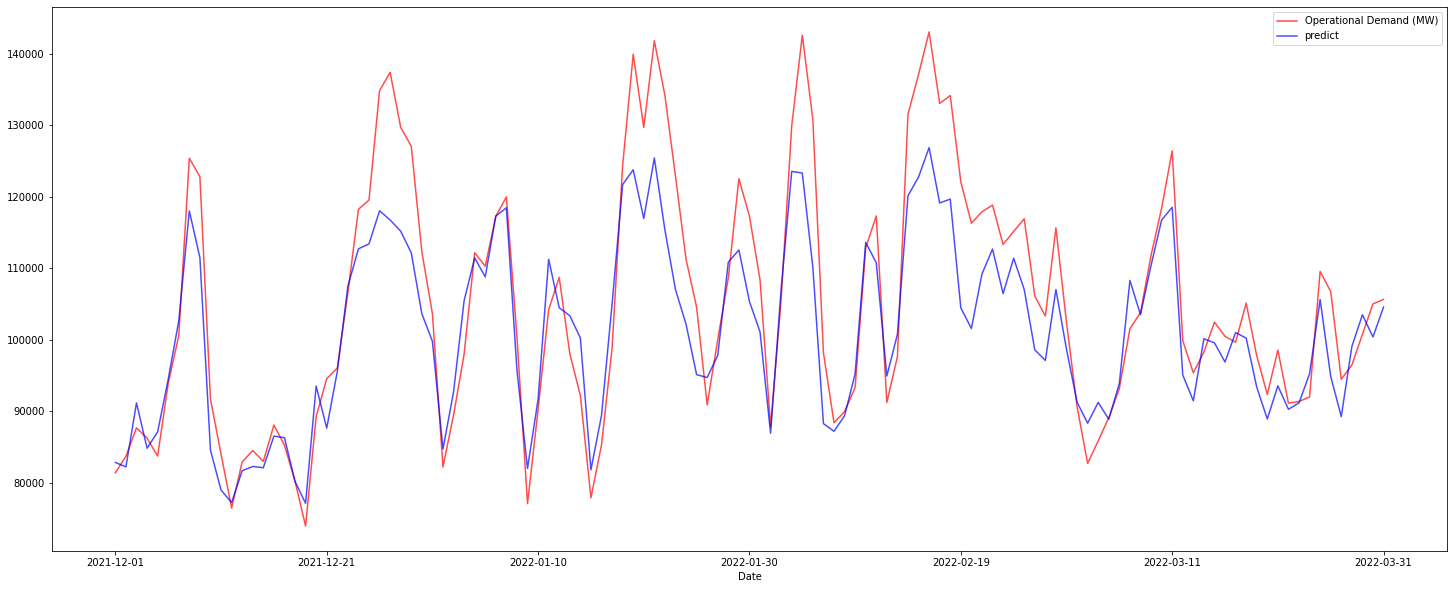

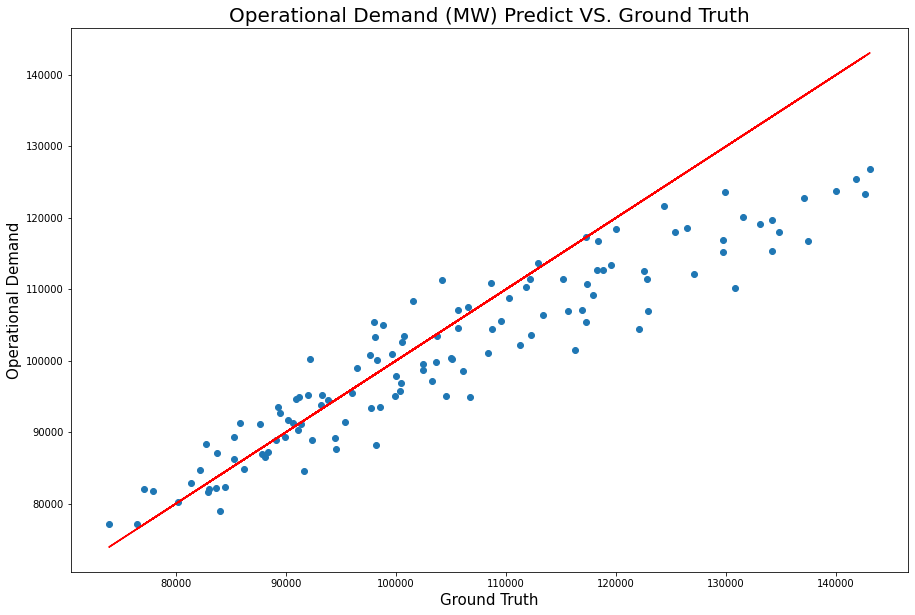

In [73]:
tree_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(tree_plot['Operational Demand (MW)'], tree_plot['predict'])
plt.plot(tree_plot['Operational Demand (MW)'],tree_plot['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [74]:
peak_day = 5 # number of top peak day we choose
peak_true_tree = agg_tree.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true_tree.index.tolist()
# peak_predict = agg_tree.sort_values('predict',ascending=False)[:peak_day]
peak_predict_tree = agg_tree[agg_tree['predict'] > ave_threshold]
predictlst=peak_predict_tree.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.4


In [75]:
peak_true_tree

Date  Operational Demand (MW)        predict
77  2022-02-16               143068.538  126888.418837
65  2022-02-04               142620.646  123324.879166
51  2022-01-21               141839.600  125434.223008
49  2022-01-19               139949.878  123783.266045
26  2021-12-27               137419.324  116759.282524

In [76]:
peak_predict_tree

Date  Operational Demand (MW)        predict
51  2022-01-21               141839.600  125434.223008
77  2022-02-16               143068.538  126888.418837

## Random Forest

In [77]:
forest = RandomForestRegressor(random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train,y_train)
y_predict_forest_test = grid_forest.predict(X_test)
print(grid_forest.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  50.6s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  57.1s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  55.9s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  43.1s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  43.1s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=  42.5s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  37.6s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  37.8s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=  38.3s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  44.9s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  45.3s
[CV] END ...................max_depth=15, min_sa

In [78]:
forest_model = RandomForestRegressor(max_depth=25, min_samples_leaf=5, random_state=42)
forest_model.fit(X_train,y_train)
y_predict_forest = forest_model.predict(X_test)

In [79]:
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('forest_model')

Mape 7.261507583197645
Mean absolute error =  158.5368
Mean squared error =  46367.2774
Median absolute error =  112.8435
explained variance error =  0.8648
R2 error =  0.8527
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     pressure(in)     | 0.2113 |
|     Day_of_week      | 0.022  |
| temperature(celcius) | 0.0205 |
|     humidity(%)      | 0.0057 |
|         year         | 0.0002 |
|   wind_speed(mph)    | 0.0014 |
|     Day_of_month     | 0.0708 |
|         hour         | 0.0095 |
|        minute        | 0.0669 |
|    wind_gush(mph)    | 0.1251 |
|  dew_point(celcius)  | 0.4629 |
|     Day_of_year      | 0.0038 |
+----------------------+--------+


In [80]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_forest = pd.DataFrame(y_test)
predict_table_forest.insert(1,'predict',y_predict_forest)
predict_table_forest

Operational Demand (MW)      predict
timestamp                                                
2021-12-01 00:00:00                 1788.716  1812.178714
2021-12-01 00:30:00                 1768.478  1802.091058
2021-12-01 01:00:00                 1756.662  1764.833078
2021-12-01 01:30:00                 1735.248  1763.619010
2021-12-01 02:00:00                 1724.418  1760.639790
...                                      ...          ...
2022-03-31 21:30:00                 2496.326  2392.787177
2022-03-31 22:00:00                 2418.866  2285.969818
2022-03-31 22:30:00                 2323.210  2252.129789
2022-03-31 23:00:00                 2245.612  2127.063673
2022-03-31 23:30:00                 2178.444  2004.828323

[5779 rows x 2 columns]

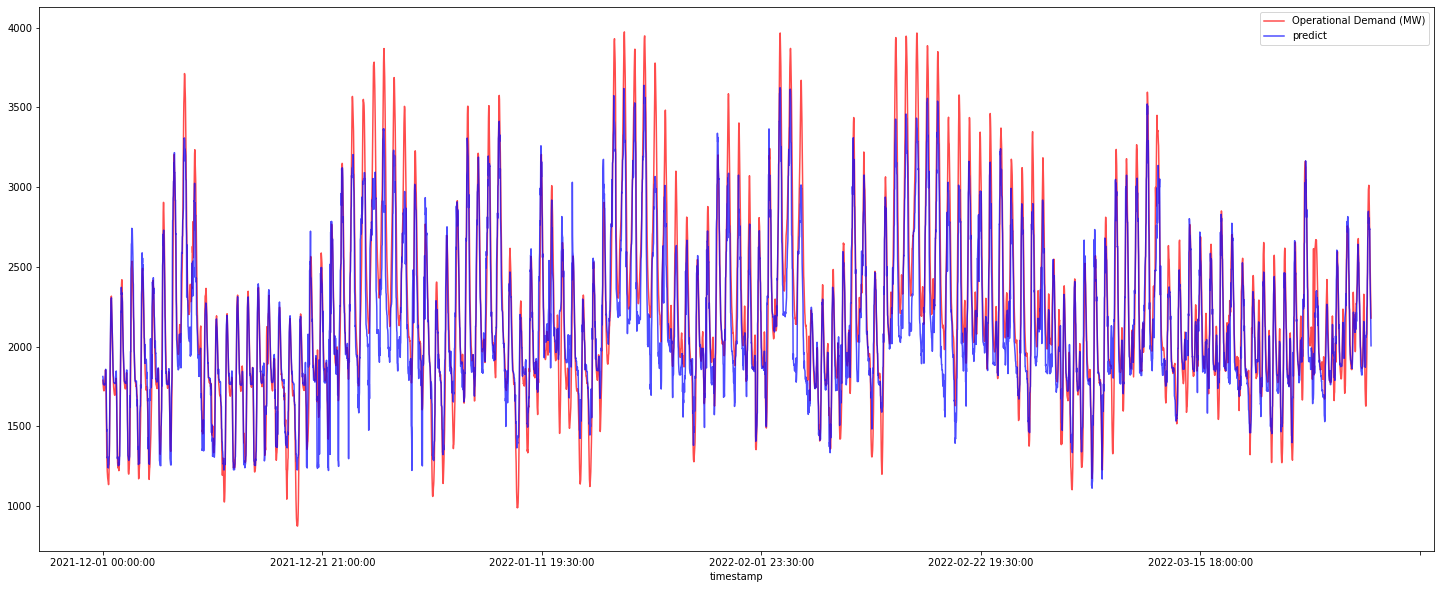

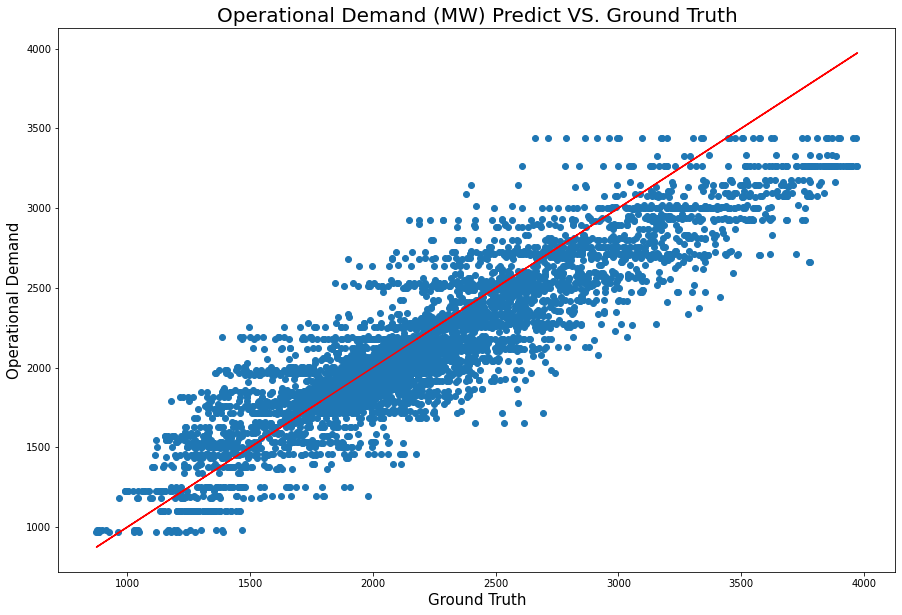

In [81]:
predict_table_forest.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [82]:
predict_table_forest['Date','time'] = predict_table_forest.index.str.split(" ",expand=True)
predict_table_forest[['Date', 'time']] = predict_table_forest[('Date', 'time')].apply(pd.Series)

predict_table_forest = predict_table_forest.drop(labels=['time',('Date','time')], axis=1)
agg_forest = pd.DataFrame(predict_table_forest.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())

In [83]:
forest_plot = agg_forest.copy()
forest_plot.index = forest_plot['Date']
forest_plot.drop('Date',axis=1)

Operational Demand (MW)        predict
Date                                              
2021-12-01                81389.002   83539.453562
2021-12-02                83692.208   84131.083207
2021-12-03                87674.768   91649.239312
2021-12-04                86230.014   88909.284500
2021-12-05                83724.146   90852.546994
...                             ...            ...
2022-03-27                94461.504   89227.920722
2022-03-28                96458.404   99324.691006
2022-03-29               100749.966  104165.367873
2022-03-30               105020.328  104125.611724
2022-03-31               105647.568  105500.416260

[121 rows x 2 columns]

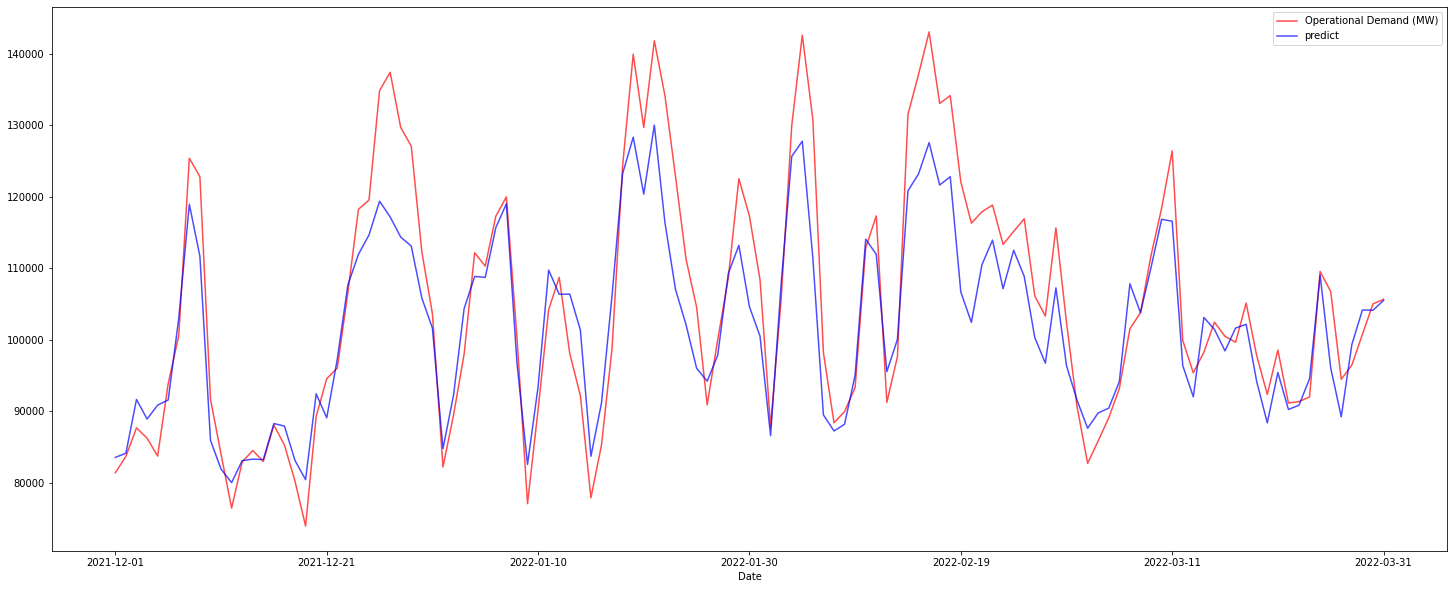

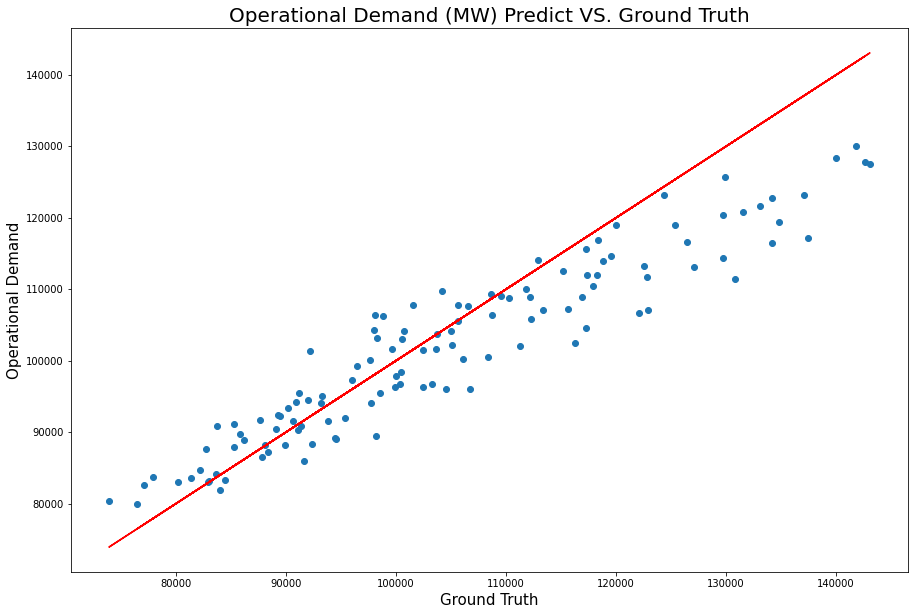

In [84]:
forest_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(forest_plot['Operational Demand (MW)'], forest_plot['predict'])
plt.plot(forest_plot['Operational Demand (MW)'],forest_plot['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [85]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_forest.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = agg_forest.sort_values('predict',ascending=False)[:peak_day]
peak_predict = agg_forest[agg_forest['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.8


In [86]:
peak_true # true peak4

Date  Operational Demand (MW)        predict
77  2022-02-16               143068.538  127583.554548
65  2022-02-04               142620.646  127784.460779
51  2022-01-21               141839.600  130036.217513
49  2022-01-19               139949.878  128333.863466
26  2021-12-27               137419.324  117187.231714

In [87]:
peak_predict # predict that higher than threshold

Date  Operational Demand (MW)        predict
49  2022-01-19               139949.878  128333.863466
51  2022-01-21               141839.600  130036.217513
64  2022-02-03               129938.672  125643.526197
65  2022-02-04               142620.646  127784.460779
77  2022-02-16               143068.538  127583.554548

## Plots of DT & RF

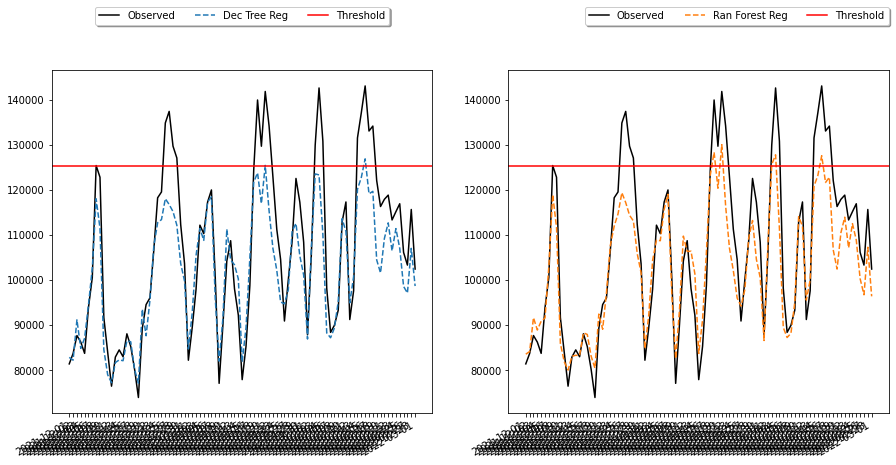

In [123]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
# Dec Tree
ax1.plot(tree_plot.loc['2021-12-01':'2022-03-01','Operational Demand (MW)'], label='Observed', c='k')
ax1.plot(tree_plot.loc['2021-12-01':'2022-03-01','predict'], label='Dec Tree Reg', ls='--', c='C0')
ax1.axhline(y = ave_threshold, label='Threshold', c='red')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),ncol=3, fancybox=True, shadow=True);

# Ran Forest
ax2.plot(forest_plot.loc['2021-12-01':'2022-03-01','Operational Demand (MW)'], label='Observed', c='k')
ax2.plot(forest_plot.loc['2021-12-01':'2022-03-01','predict'], label='Ran Forest Reg', ls='--', c='C1')
ax2.axhline(y = ave_threshold, label='Threshold', c='red')
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, 1.20), ncol=3, fancybox=True, shadow=True);

fig.autofmt_xdate()

## Forecast

In [88]:
%run -i 'fetch_forecast.py'

Weather forecast fetched till 2022-11-01 23:00


In [89]:
fore = pd.read_csv('forecast.csv', index_col = 0)
fore.head()

temperature(celcius)  dew_point(celcius)  humidity(%) Wind  \
timestamp                                                                      
2022-10-19 00:00                  15.1                 8.8           66  SSE   
2022-10-19 01:00                  15.0                 8.1           63   SE   
2022-10-19 02:00                  15.0                 7.2           60  ESE   
2022-10-19 03:00                  15.0                 6.5           57    E   
2022-10-19 04:00                  14.8                 6.2           56    E   

                  wind_speed(mph)  wind_gush(mph)  pressure(in) precip.(in)  \
timestamp                                                                     
2022-10-19 00:00              7.2            13.9         29.98       Clear   
2022-10-19 01:00              4.9            10.1         29.97       Clear   
2022-10-19 02:00              4.5             9.2         29.95       Clear   
2022-10-19 03:00              5.1            10.7         29.93       Clear   
2022-10-19 04:00              5.8            11.9         29.92       Clear   

                  Condition  
timestamp                    
2022-10-19 00:00        NaN  
2022-10-19 01:00        NaN  
2022-10-19 02:00        NaN  
2022-10-19 03:00        NaN  
2022-10-19 04:00        NaN

In [90]:
fore

temperature(celcius)  dew_point(celcius)  humidity(%) Wind  \
timestamp                                                                      
2022-10-19 00:00                  15.1                 8.8           66  SSE   
2022-10-19 01:00                  15.0                 8.1           63   SE   
2022-10-19 02:00                  15.0                 7.2           60  ESE   
2022-10-19 03:00                  15.0                 6.5           57    E   
2022-10-19 04:00                  14.8                 6.2           56    E   
...                                ...                 ...          ...  ...   
2022-11-01 19:00                  18.5                13.6           73   SW   
2022-11-01 20:00                  17.7                13.2           75   SW   
2022-11-01 21:00                  17.4                13.1           76   SW   
2022-11-01 22:00                  17.1                12.9           77   SW   
2022-11-01 23:00                  16.8                12.8           77  SSW   

                  wind_speed(mph)  wind_gush(mph)  pressure(in)  \
timestamp                                                         
2022-10-19 00:00              7.2            13.9         29.98   
2022-10-19 01:00              4.9            10.1         29.97   
2022-10-19 02:00              4.5             9.2         29.95   
2022-10-19 03:00              5.1            10.7         29.93   
2022-10-19 04:00              5.8            11.9         29.92   
...                           ...             ...           ...   
2022-11-01 19:00              8.5            11.0         29.95   
2022-11-01 20:00              7.6            10.7         29.96   
2022-11-01 21:00              7.2            10.1         29.96   
2022-11-01 22:00              6.5             9.6         29.95   
2022-11-01 23:00              6.0             8.9         29.94   

                    precip.(in)  Condition  
timestamp                                   
2022-10-19 00:00          Clear        NaN  
2022-10-19 01:00          Clear        NaN  
2022-10-19 02:00          Clear        NaN  
2022-10-19 03:00          Clear        NaN  
2022-10-19 04:00          Clear        NaN  
...                         ...        ...  
2022-11-01 19:00  Partly cloudy        NaN  
2022-11-01 20:00  Partly cloudy        NaN  
2022-11-01 21:00          Clear        NaN  
2022-11-01 22:00  Partly cloudy        NaN  
2022-11-01 23:00          Clear        NaN  

[336 rows x 9 columns]

In [91]:
fore['timestamp'] = fore.index
fore = create_time_features(fore)
fore_set = fore[x_col]
predict_fore = grid_forest.predict(fore_set)
fore_predict = pd.DataFrame()
fore_predict['predict'] = predict_fore
fore_predict.index = fore['timestamp']
fore_predict


predict
timestamp                    
2022-10-19 00:00  1840.923444
2022-10-19 01:00  1840.923444
2022-10-19 02:00  1840.923444
2022-10-19 03:00  1636.749254
2022-10-19 04:00  1636.749254
...                       ...
2022-11-01 19:00  2129.973539
2022-11-01 20:00  2129.313539
2022-11-01 21:00  2129.950922
2022-11-01 22:00  2131.631240
2022-11-01 23:00  2131.631240

[336 rows x 1 columns]

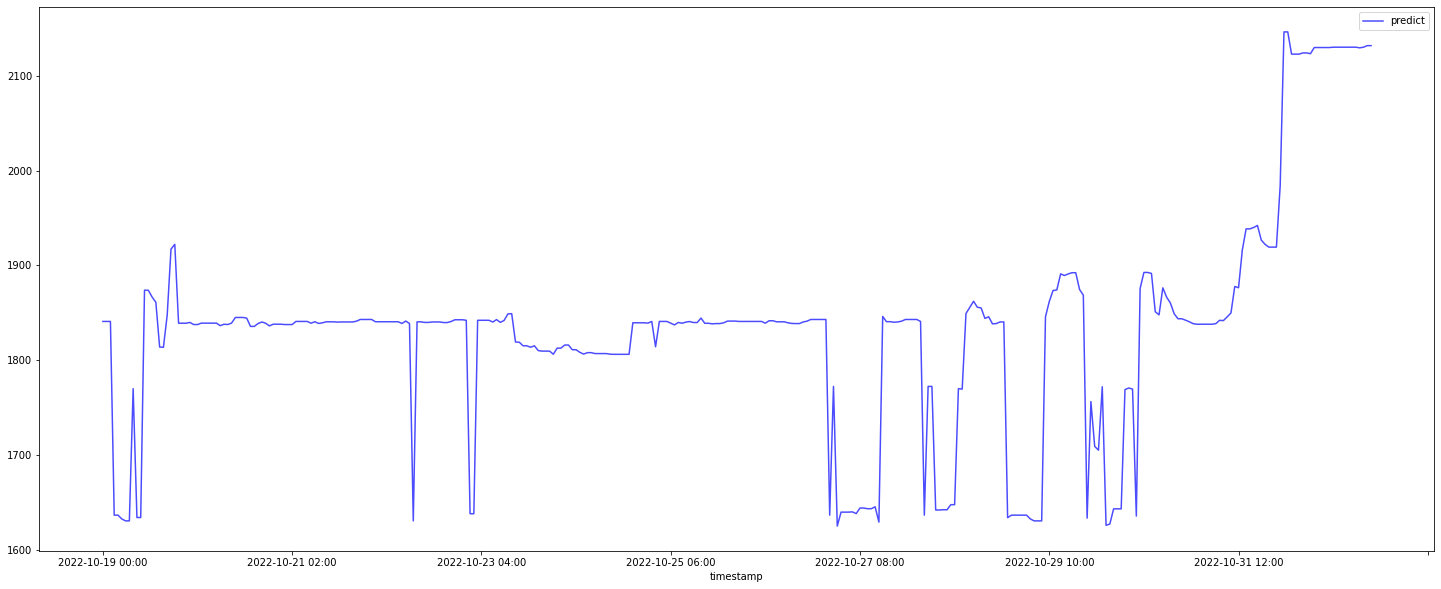

In [92]:
fore_predict.plot.line(figsize = (25,10), color = 'blue',alpha = 0.7)
plt.show()

In [93]:
fore_predict['Date','time'] = fore_predict.index.str.split(" ",expand=True)
fore_predict[['Date', 'time']] = fore_predict[('Date', 'time')].apply(pd.Series)

fore_predict = fore_predict.drop(labels=['time',('Date','time')], axis=1)
agg_fore = pd.DataFrame(fore_predict.groupby(['Date'])['predict'].sum().reset_index())

In [94]:
fore_plot = agg_fore.copy()
fore_plot.index = fore_plot['Date']
fore_plot.drop('Date',axis=1)

predict
Date                    
2022-10-19  42876.432193
2022-10-20  44141.982543
2022-10-21  44171.207281
2022-10-22  43964.253565
2022-10-23  43493.735535
2022-10-24  43534.925803
2022-10-25  44134.543779
2022-10-26  44182.707276
2022-10-27  41504.713562
2022-10-28  42387.363878
2022-10-29  42167.817070
2022-10-30  42975.044355
2022-10-31  45267.032796
2022-11-01  51111.579781

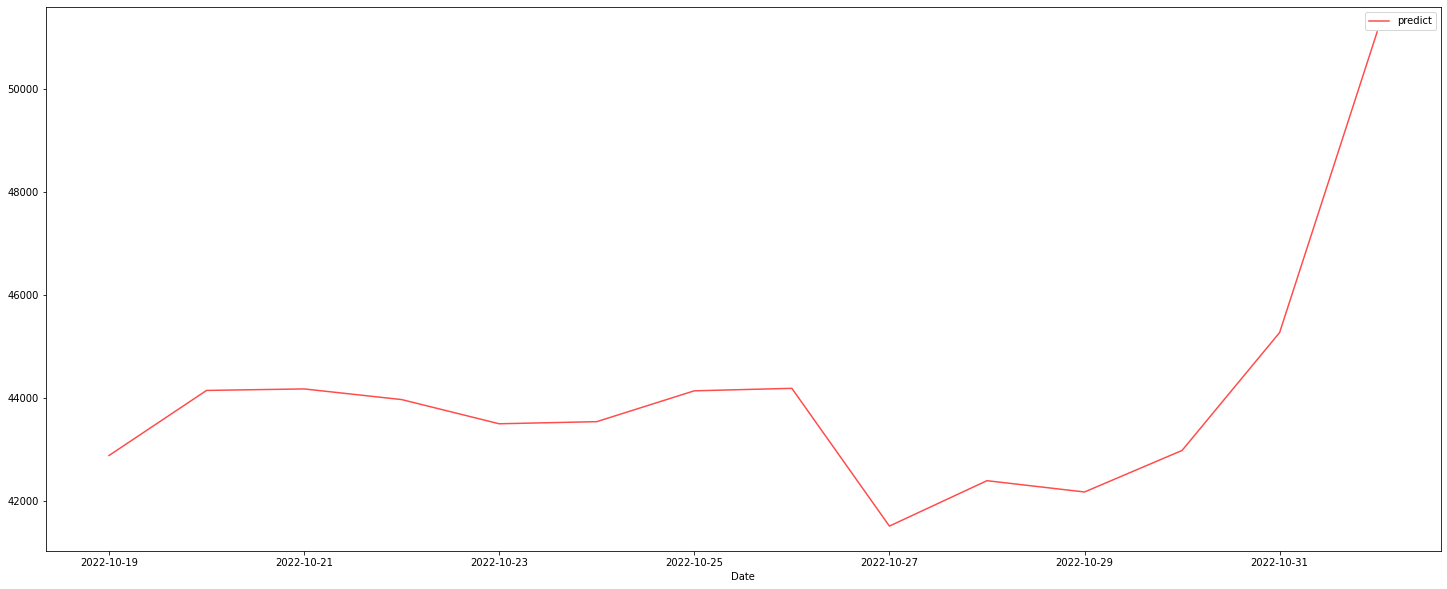

In [95]:
fore_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()

## SHAP Explain

In [103]:
shap_train = model_df[(model_df.index < '2021-12-01') & (model_df.index > '2017-12-01')]
X_train_shap = shap_train.drop('Operational Demand (MW)',axis=1)
y_train_shap = shap_train['Operational Demand (MW)']

In [104]:
forest_model = RandomForestRegressor(max_depth=25, min_samples_leaf=5, random_state=42)
forest_model.fit(X_train_shap,y_train_shap)
y_predict_forest = forest_model.predict(X_test)

In [106]:
shap.initjs()
row_choose = 3
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[row_choose], X_test.iloc[row_choose])

In [107]:
shap.force_plot(explainer.expected_value, shap_values,X_test)

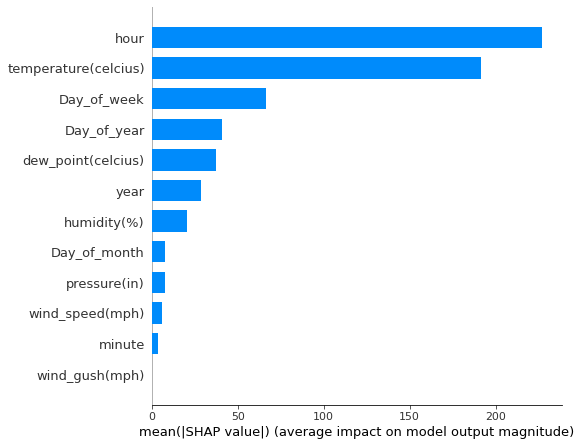

In [117]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

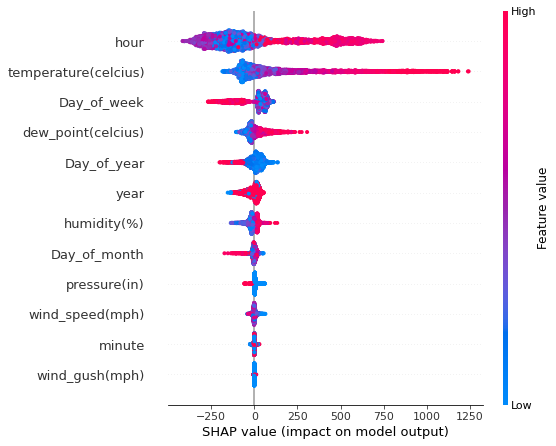

In [116]:
shap.summary_plot(shap_values, X_test)

In [121]:
# # # Part
# shap.dependence_plot('dew_point(celcius)', shap_values)

AttributeError: 'NoneType' object has no attribute 'shape'